In [ ]:
!pip install qiskit
!pip install qiskit_optimization
!pip install pylatexenc

In [ ]:
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit.visualization import *
from qiskit_optimization import *
from qiskit_optimization.algorithms import GroverOptimizer
from qiskit.algorithms import *
import numpy as np
import math

# Let's construct the Grover’s algorithm at gate level to search the state |110>.
Then let's do the same with the Grover’s function that Qiskit provides.

###First, let's perform the Grover's algorithm for 3 qubits to search the state $|110\rangle$:

\begin{equation*}
U_w = 
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{pmatrix}
\end{equation*}

In [ ]:
# Using the tools seen in class 2, let's construct the circuit for this oracle
U = Operator([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,1]])
print(U)

Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            1.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


In [ ]:
U.is_unitary()

True

### Once we know the matrix is unitary, therefore a valid quanutm operator, we can convert our Oracle into a Quantum Circuit
### Let's build it and run some tests.
#### We'll build the oracle, send the state 110 through it and observe that the phase changes

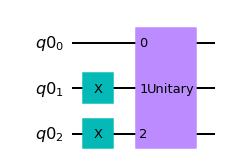

In [ ]:
num_qubits = 3
qr = QuantumRegister(num_qubits)

qcirc = QuantumCircuit(qr)
# state 110 (qiskit prints them from bottom to top)
qcirc.x(1)
qcirc.x(2)
qcirc.append(U, qr)
qcirc.draw('mpl')

#### observe the -1 in the 7th position of the array

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qcirc, backend)
result = job.result()
state = result.get_statevector()
print(state)

[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]


### Now that we created the oracle, let's build the main circuit

In [ ]:
def get_search_iteration_circuit_110(num_qubits = 3):
  qr = QuantumRegister(num_qubits)
  qcirc = QuantumCircuit(qr)
  
  qcirc.append(U, qr)

  qcirc.barrier()
  # Diffuser operator to amplify the amplitude
  for qubit in range(num_qubits):
      qcirc.h(qubit)
  for qubit in range(num_qubits):
      qcirc.x(qubit)
  qcirc.h(num_qubits-1)
  qcirc.mct(list(range(num_qubits-1)), num_qubits-1)
  qcirc.h(num_qubits-1)
  for qubit in range(num_qubits):
      qcirc.x(qubit)
  for qubit in range(num_qubits):
      qcirc.h(qubit)
  
  return qcirc


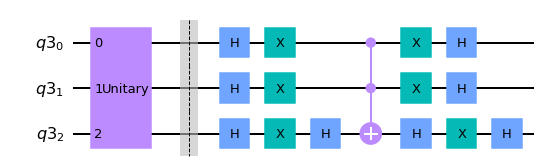

In [ ]:
c = get_search_iteration_circuit_110()
c.draw('mpl')

In [ ]:
def search_for_110(num_iterations):
  qr = QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  # Initializing the circuit
  for i in range(num_qubits):
      circuit.h(i)

  for i in range(num_iterations):
    circuit.append(get_search_iteration_circuit_110(), qr)
  circuit.measure_all()

  backend = Aer.get_backend('qasm_simulator')
  results = execute(circuit, backend=backend, shots=1024).result()
  answer = results.get_counts()
  return answer

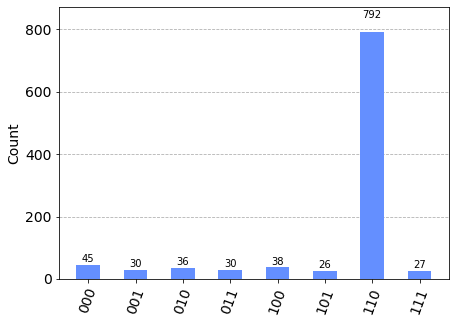

In [ ]:
plot_histogram(search_for_110(1))

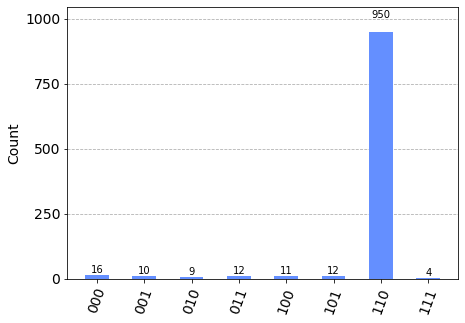

In [ ]:
plot_histogram(search_for_110(2))

## Now let's do it with qiskit functionalities

In [ ]:
# First, we need to know how many iterations we need to carry out
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=3)
print(iterations)

2


In [ ]:
DESIRED_STATE = '110'
# Implementing the oracle of the first step
oracle_qr = QuantumRegister(num_qubits)
oracle = QuantumCircuit(oracle_qr)
oracle.append(U, oracle_qr)

# The states we are searching for
good_states = [DESIRED_STATE]
grover_circuit = AmplificationProblem(oracle=oracle, is_good_state=good_states)
simulator = Aer.get_backend('qasm_simulator')
grover = Grover(quantum_instance=simulator)
result = grover.amplify(grover_circuit)

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
grover = Grover(quantum_instance=simulator)
result = grover.amplify(grover_circuit)

In [ ]:
print(result)
print(result.top_measurement)
print('\n The correct results are:', result.circuit_results[0].keys())

{   'assignment': '110',
    'circuit_results': [   {   '000': 36,
                               '001': 35,
                               '010': 30,
                               '011': 28,
                               '100': 30,
                               '101': 22,
                               '110': 810,
                               '111': 33}],
    'iterations': [1],
    'max_probability': 0.791015625,
    'oracle_evaluation': True,
    'top_measurement': '110'}
110

 The correct results are: dict_keys(['111', '011', '101', '010', '000', '100', '001', '110'])


## It can be observed that the results are the same as in the circuit built at gate level